In [1]:
# load the data
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

--2025-11-02 18:07:03--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.006s  

2025-11-02 18:07:03 (140 MB/s) - ‘car_fuel_efficiency.csv’ saved [874188/874188]



##1. Data Preprocessing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("car_fuel_efficiency.csv")
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9704 entries, 0 to 9703
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   engine_displacement  9704 non-null   int64  
 1   num_cylinders        9222 non-null   float64
 2   horsepower           8996 non-null   float64
 3   vehicle_weight       9704 non-null   float64
 4   acceleration         8774 non-null   float64
 5   model_year           9704 non-null   int64  
 6   origin               9704 non-null   object 
 7   fuel_type            9704 non-null   object 
 8   drivetrain           9704 non-null   object 
 9   num_doors            9202 non-null   float64
 10  fuel_efficiency_mpg  9704 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 834.1+ KB


In [5]:
df.isna().sum()

,0
engine_displacement,0
num_cylinders,482
horsepower,708
vehicle_weight,0
acceleration,930
model_year,0
origin,0
fuel_type,0
drivetrain,0
num_doors,502


In [6]:
missing_cols = [col for col in df.columns if df[col].isna().sum() > 0]
missing_cols

['num_cylinders', 'horsepower', 'acceleration', 'num_doors']

###Fill missing values with zeros.


In [7]:
df[missing_cols] = df[missing_cols].fillna(0)
df.isna().sum()

,0
engine_displacement,0
num_cylinders,0
horsepower,0
vehicle_weight,0
acceleration,0
model_year,0
origin,0
fuel_type,0
drivetrain,0
num_doors,0


###Do train/validation/test split with 60%/20%/20% distribution.


In [8]:
X = df.drop(columns='fuel_efficiency_mpg')
y = df.fuel_efficiency_mpg

In [9]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=1)

###Use DictVectorizer(sparse=True) to turn the dataframes into matrices and handle catgorical columns.


In [10]:
dv = DictVectorizer(sparse=True)
train_dict = X_train.to_dict(orient='records')
val_dict = X_val.to_dict(orient='records')

X_train_dict = dv.fit_transform(train_dict)
X_val_dict = dv.transform(val_dict)

In [11]:
dv.get_feature_names_out()

array(['acceleration', 'drivetrain=All-wheel drive',
       'drivetrain=Front-wheel drive', 'engine_displacement',
       'fuel_type=Diesel', 'fuel_type=Gasoline', 'horsepower',
       'model_year', 'num_cylinders', 'num_doors', 'origin=Asia',
       'origin=Europe', 'origin=USA', 'vehicle_weight'], dtype=object)

### Q1. Let's train a decision tree regressor to predict the fuel_efficiency_mpg variable.

- Train a model with max_depth=1.


In [12]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=1)
model.fit(X_train_dict, y_train)

DecisionTreeRegressor(max_depth=1)

In [13]:
model.feature_importances_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [14]:
# visualize the tree
from sklearn.tree import export_text

print(export_text(model, feature_names=dv.feature_names_))

|--- vehicle_weight <= 3028.82
|   |--- value: [16.86]
|--- vehicle_weight >  3028.82
|   |--- value: [12.87]



Clearly, vehicle_weight is the feature the tree has split upon, when its `depth=1`

###Q2. Question 2
- Train a random forest regressor with these parameters:

    - `n_estimators=10`
    - `random_state=1`
    - `n_jobs=-1` (optional - to make training faster)
    
What's the RMSE of this model on the validation data?

In [15]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)
rf.fit(X_train_dict, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [16]:
from sklearn.metrics import root_mean_squared_error as rmse

y_preds = rf.predict(X_val_dict)
score = rmse(y_val, y_preds)
print(f"RMSE of the tree: {score:.3f}")

RMSE of the tree: 0.460


So we got the `RMSE` on the validation set as `0.46`.

###Question 3
> Now let's experiment with the **n_estimators** parameter

    - Try different values of this parameter from 10 to 200 with step 10.
    - Set random_state to 1.
    - Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for calculating the answer.

In [17]:
from tqdm import tqdm

vals = np.arange(10, 200, 10)
scores = []

for val in tqdm(vals):
    rfr = RandomForestRegressor(n_estimators=val, random_state=1)
    rfr.fit(X_train_dict, y_train)
    y_pred = rfr.predict(X_val_dict)
    score = rmse(y_val, y_pred)
    scores.append((val, round(score, 3)))

100%|██████████| 19/19 [05:55<00:00, 18.70s/it]


In [18]:
scores[:10]

[(np.int64(10), 0.46),
 (np.int64(20), 0.446),
 (np.int64(30), 0.44),
 (np.int64(40), 0.438),
 (np.int64(50), 0.437),
 (np.int64(60), 0.436),
 (np.int64(70), 0.436),
 (np.int64(80), 0.436),
 (np.int64(90), 0.435),
 (np.int64(100), 0.435)]

In [19]:
df_score = pd.DataFrame(scores, columns=['n_estimators', 'RMSE'])
df_score.sort_values(by='RMSE')

,n_estimators,RMSE
15,160,0.435
14,150,0.435
13,140,0.435
12,130,0.435
11,120,0.435
10,110,0.435
9,100,0.435
8,90,0.435
17,180,0.435
18,190,0.435


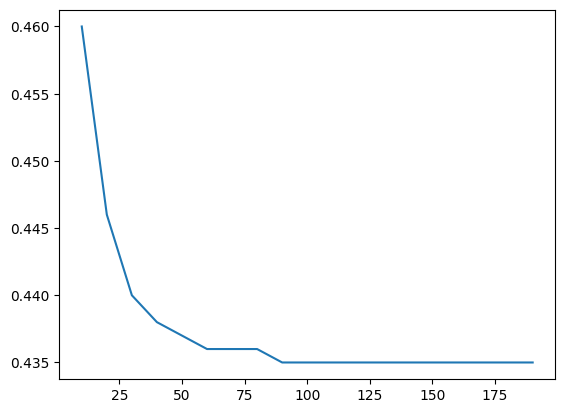

In [20]:
plt.plot(df_score.n_estimators, df_score.RMSE);

As we can see, around `n_iterations = 80` we see a flat line indicating no improvement in RMSE

###Question 4
Let's select the `best max_depth`:

1. Try different values of max_depth: [10, 15, 20, 25]
2. For each of these values,
try different values of n_estimators from 10 till 200 (with step 10)
calculate the mean RMSE
3. Fix the random seed: random_state=1

What's the best `max_depth`, using the mean RMSE?



In [21]:
max_d = [10, 15, 20, 25] # max depth
vals = np.arange(10, 200, 10) # n_estimators

scores_2 = []

for val in tqdm(max_d):
    for n_est in vals:
        rf = RandomForestRegressor(max_depth=val, n_estimators=n_est, random_state=1)
        rf.fit(X_train_dict, y_train)
        y_pred = rf.predict(X_val_dict)
        score = rmse(y_val, y_pred)
        scores_2.append((val, n_est, round(score, 3)))

100%|██████████| 4/4 [19:34<00:00, 293.61s/it]


In [25]:
scores_2[:10]

[(10, np.int64(10), 0.451),
 (10, np.int64(20), 0.443),
 (10, np.int64(30), 0.438),
 (10, np.int64(40), 0.437),
 (10, np.int64(50), 0.436),
 (10, np.int64(60), 0.435),
 (10, np.int64(70), 0.435),
 (10, np.int64(80), 0.435),
 (10, np.int64(90), 0.435),
 (10, np.int64(100), 0.435)]

In [28]:
df_score_2 = pd.DataFrame(scores_2, columns=['max_depth', 'n_estimators', 'rmse'])
df_score_2.head()
# df_score_2.to_csv('saved1.csv', index=False)

,max_depth,n_estimators,rmse
0,10,10,0.451
1,10,20,0.443
2,10,30,0.438
3,10,40,0.437
4,10,50,0.436


In [31]:
df_score_2.sort_values(by='rmse').head(10)

,max_depth,n_estimators,rmse
12,10,130,0.434
13,10,140,0.434
10,10,110,0.434
11,10,120,0.434
17,10,180,0.434
18,10,190,0.434
16,10,170,0.434
6,10,70,0.435
14,10,150,0.435
9,10,100,0.435


The best `max_depth` for the model seems to be around **10**, which gives the lowest `rmse` of all.

###Question 5
    Train the model with these parameters:
        n_estimators=10,
        max_depth=20,
        random_state=1,
        n_jobs=-1 (optional)
Get the feature importance information from this model

In [32]:
model_5 = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
model_5.fit(X_train_dict, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [48]:
feat_imp = list(model_5.feature_importances_)
print(type(feat_imp))

<class 'list'>


In [46]:
names = dv.feature_names_
print(type(names))

<class 'list'>


In [66]:
feat_map = {}
for f, v in zip(names, feat_imp):
    feat_map[f] = v

df_feat = pd.DataFrame([feat_map])
df_feat.T.sort_values(by=0, ascending=False)

,0
vehicle_weight,0.959878
horsepower,0.015933
acceleration,0.011442
engine_displacement,0.003159
model_year,0.003066
num_cylinders,0.002323
num_doors,0.001576
origin=USA,0.000496
origin=Asia,0.000431
origin=Europe,0.000419


As we see, `vehicle_weight` is the most important feature as per the Random Forest Regressor.

###Question 6
Now let's train an XGBoost model! For this question, we'll tune the eta parameter:



In [67]:
import xgboost as xgb

In [73]:
# Create the DMatrix for XGBoost
features = dv.feature_names_
dtrain = xgb.DMatrix(X_train_dict, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val_dict, label=y_val, feature_names=features)

**Parameters and their layman meaning**
- `eta`: learning rate
- `max_depth`: max depth of the each decision tree
- `min_child_weight`: it prevents the creation of leaves that contain too little "information"
- `objective`: regression: rmse
- `nthread`: for parallel processing
- `seed` - you know!
- `verbosity`: errors, warnings etc
- `watchlist`: contains both train and eval data so that the training and evaluation on validation is done at each step
- `verbose_eval`: after how many iterations you want the model to give out the train and val rmse
- `num_boost_rounds`: how many gb trees you want to create

In [76]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [78]:
%%capture op
x_model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=100)

In [80]:
print(op.stdout)

[0]	train-rmse:1.83282	val-rmse:1.82567
[5]	train-rmse:0.51643	val-rmse:0.54010
[10]	train-rmse:0.37400	val-rmse:0.43004
[15]	train-rmse:0.34792	val-rmse:0.42450
[20]	train-rmse:0.33724	val-rmse:0.42509
[25]	train-rmse:0.32515	val-rmse:0.42667
[30]	train-rmse:0.31757	val-rmse:0.42754
[35]	train-rmse:0.30703	val-rmse:0.42903
[40]	train-rmse:0.29886	val-rmse:0.43086
[45]	train-rmse:0.28934	val-rmse:0.43245
[50]	train-rmse:0.28277	val-rmse:0.43405
[55]	train-rmse:0.27370	val-rmse:0.43501
[60]	train-rmse:0.26525	val-rmse:0.43583
[65]	train-rmse:0.25625	val-rmse:0.43706
[70]	train-rmse:0.24983	val-rmse:0.43777
[75]	train-rmse:0.24110	val-rmse:0.43803
[80]	train-rmse:0.23379	val-rmse:0.43902
[85]	train-rmse:0.22874	val-rmse:0.43986
[90]	train-rmse:0.22023	val-rmse:0.44154
[95]	train-rmse:0.21304	val-rmse:0.44281
[99]	train-rmse:0.20896	val-rmse:0.44340



In [88]:
s = op.stdout
lines = s.split("\n")
lines[0]

'[0]\ttrain-rmse:1.83282\tval-rmse:1.82567'

In [90]:
lines[0].split("\t")

['[0]', 'train-rmse:1.83282', 'val-rmse:1.82567']

In [95]:
res = []

for line in lines:
    if line.strip():
        it_line, train_line, val_line = line.split("\t")

    it = int(it_line.strip('[]'))
    train = float(train_line.split(':')[1])
    val = float(val_line.split(':')[1])

    res.append((it, train, val))

cols = ['num_iter', 'train_rmse', 'val_rmse']
df_res = pd.DataFrame(res, columns=cols)

df_res

,num_iter,train_rmse,val_rmse
0,0,1.83282,1.82567
1,5,0.51643,0.54010
2,10,0.37400,0.43004
3,15,0.34792,0.42450
4,20,0.33724,0.42509
5,25,0.32515,0.42667
6,30,0.31757,0.42754
7,35,0.30703,0.42903
8,40,0.29886,0.43086
9,45,0.28934,0.43245


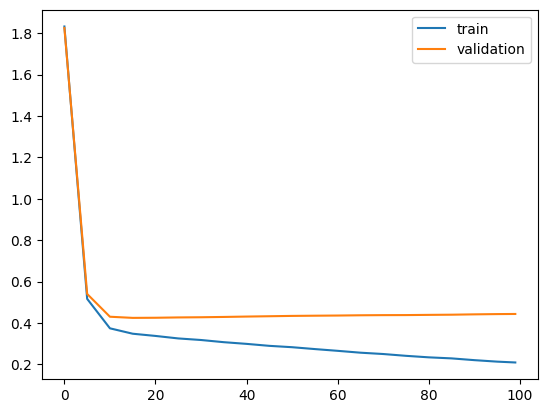

In [98]:
plt.plot(df_res.num_iter, df_res.train_rmse, label='train')
plt.plot(df_res.num_iter, df_res.val_rmse, label='validation')
plt.legend();

In [104]:
def parse_output_from_xgb(op):
    res = []

    for line in op.stdout.split("\n"):
        if line.strip():
            it_line, train_line, val_line = line.split("\t")

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        res.append((it, train, val))

    cols = ['num_iter', 'train_rmse', 'val_rmse']
    df_res = pd.DataFrame(res, columns=cols)

    return df_res

df_op = parse_output_from_xgb(op)
df_op

,num_iter,train_rmse,val_rmse
0,0,1.83282,1.82567
1,5,0.51643,0.54010
2,10,0.37400,0.43004
3,15,0.34792,0.42450
4,20,0.33724,0.42509
5,25,0.32515,0.42667
6,30,0.31757,0.42754
7,35,0.30703,0.42903
8,40,0.29886,0.43086
9,45,0.28934,0.43245


###Iterating again with `eta: 0.1`.



In [100]:
xgb_params_2 = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [102]:
%%capture op2
model_final = xgb.train(xgb_params_2, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=100)

In [103]:
df_op2 = parse_output_from_xgb(op2)
df_op2

,num_iter,train_rmse,val_rmse
0,0,2.31334,2.30592
1,5,1.42645,1.42157
2,10,0.91846,0.92183
3,15,0.63889,0.65351
4,20,0.49316,0.52039
5,25,0.42094,0.46085
6,30,0.38552,0.43528
7,35,0.36644,0.42379
8,40,0.35546,0.41889
9,45,0.34800,0.41680


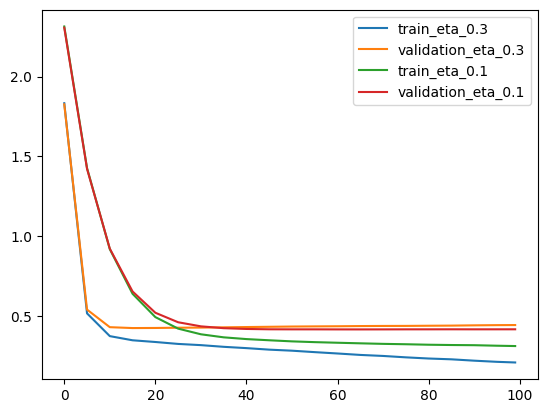

In [105]:
# Plot all the curves
plt.plot(df_op.num_iter, df_op.train_rmse, label='train_eta_0.3')
plt.plot(df_op.num_iter, df_op.val_rmse, label='validation_eta_0.3')
plt.plot(df_op2.num_iter, df_op2.train_rmse, label='train_eta_0.1')
plt.plot(df_op2.num_iter, df_op2.val_rmse, label='validation_eta_0.1')

plt.legend();

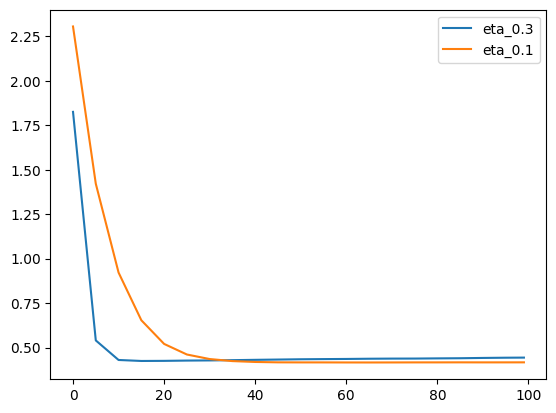

In [106]:
# Exclusively on the validation set
plt.plot(df_op.num_iter, df_op.val_rmse, label='eta_0.3')
plt.plot(df_op2.num_iter, df_op2.val_rmse, label='eta_0.1')
plt.legend();

As seen `eta:0.1` has a smoother curve and it crosses below the blue line around `35` **iterations**.

In [110]:
model_final.get_score()

{'acceleration': 1219.0,
 'drivetrain=All-wheel drive': 92.0,
 'engine_displacement': 522.0,
 'fuel_type=Diesel': 92.0,
 'horsepower': 1195.0,
 'model_year': 406.0,
 'num_cylinders': 332.0,
 'num_doors': 204.0,
 'origin=Asia': 45.0,
 'origin=Europe': 43.0,
 'origin=USA': 52.0,
 'vehicle_weight': 893.0}

### Let's calculate the MAE on the test set

In [111]:
from sklearn.metrics import mean_absolute_error

test_dict = X_test.to_dict(orient='records')
X_test_dict = dv.transform(test_dict)

dtest = xgb.DMatrix(X_test_dict, label=y_test, feature_names=features)
y_preds_test = model_final.predict(dtest)
mae = mean_absolute_error(y_true=y_test, y_pred=y_preds_test)
print(f"MAE on test data: {mae:.3f}")

MAE on test data: 0.336


We got surprisingly **lower rmse** on the test set as compared to train and val sets!

Checking out $R^2$ score as well.

In [113]:
from sklearn.metrics import r2_score

print(f"R2 score of the model: {r2_score(y_test, y_preds_test):.3f}")

R2 score of the model: 0.972


Through this notebook, we witnessed the power of **XGBoost** algorithm and why it's so respected!